Pick and Place Study
====================
This is a simple notebook to test the accuracy and precision of the pick and place tooling/software being used in FPIX module assembly.

the procedure to acquire the data is the following:
  1. **Manually place an HDI on a pre-calibrated slot.** This is important simply because it gives the vision system a place to initially find the HDI.
  2. **Use the camera system to locate the center/orientation of the HDI.** Output this data to the log.
  3. **Acquire the `Picker` tool from the tool rack.**
  4. **Bring the picker tool over the center of the module.**
  5. **Rotate to match the module's rotation. (found in step 2)**
  6. **Bring the suction cups on the `Picker` tool in contact with the surface of the HDI.**
  7. **Turn on vacuum to the suction cups, wait .5s.**
  8. **Release vacuum to the chuck, wait .5s.**
  9. **Raise the `Picker` tool 5mm, bringing the HDI with it.**
  10. **Rotate the `Picker` tool back to 0.**
  11. **Bring gantry to the chuck's "Home" position**
  12. **Position the `Picker` tool over the "target position"\*. **
  13. **Rotate the `Picker` tool to match the target rotation.**
  14. **Bring HDI in contact with surface of chuck.**
  15. **Turn on chuck vacuum, wait .5s.**
  16. **Turn off suction cup vacuum, wait .5s.**
  17. **Raise `Picker` tool 5mm**
  18. **Rotate the `Picker` tool back to 0.**
  19. **Return `Picker` tool to the tool rack.**
  20. **Go back to step 2.**
  
  
\*The target position is shifted 1mm in x and y with respect to the initial position so the HDI doesn't catch the edges of the stencil.

In [2]:
import matplotlib
%matplotlib notebook
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
plt.style.use('fivethirtyeight')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [12,8]

from pick_and_place_data import data

In [3]:
class Observation:
    def __init__(self, i, x, y, z , t):
        self.i = i
        self.x = x*1000
        self.y = y*1000
        self.z = z*1000
        self.t = t
    def __repr__(self):
        fmt = ("Observation {}:\n\tx={:7.3f}\n\ty={:7.3f}"
               "\n\tz={:7.3f}\n\tt={:+7.3f}\n")
        return fmt.format(self.i, self.x, self.y, self.z, self.t)

obs = {key: [Observation(i, *val[i*4:(i+1)*4]) for i in range(len(val)//4)] for key,val in data.items()}


def net_phi(*quat):
    from Quaternion import Quat
    quat = [float(q) for q in quat]
    quat = Quat(quat)
    v = np.array([1,0,0])
    v = quat.transform @ v
    return np.arctan2(v[1],v[0]) * 180/np.pi

target = Observation(0,632.521120,551.126947,63.003312, net_phi(0.000000,-0.000000,0.000662,-1.000000))
print(target)

Observation 0:
	x=632521.120
	y=551126.947
	z=63003.312
	t= -0.076



<IPython.core.display.Javascript object>


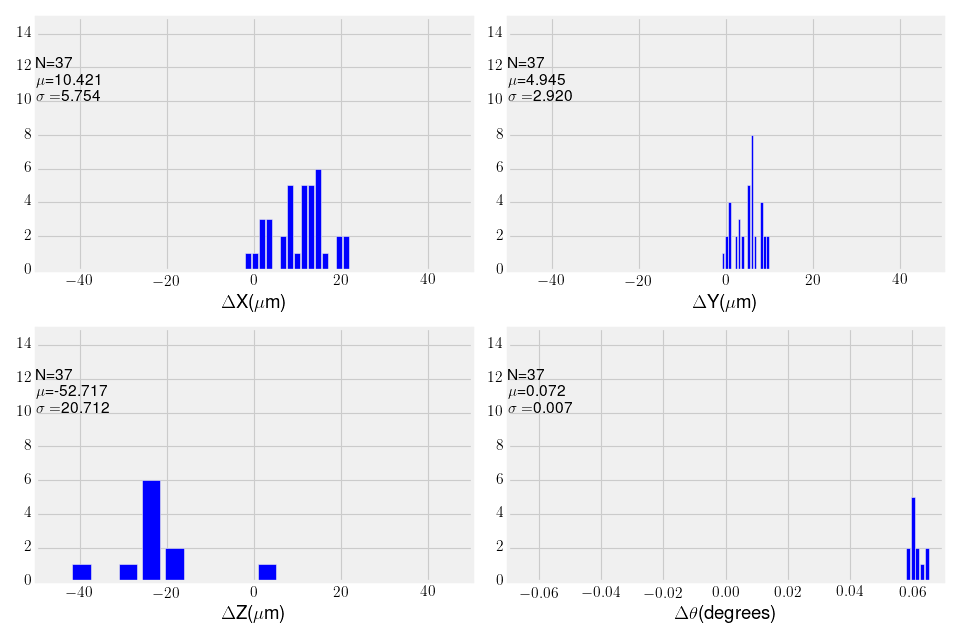

<IPython.core.display.Javascript object>


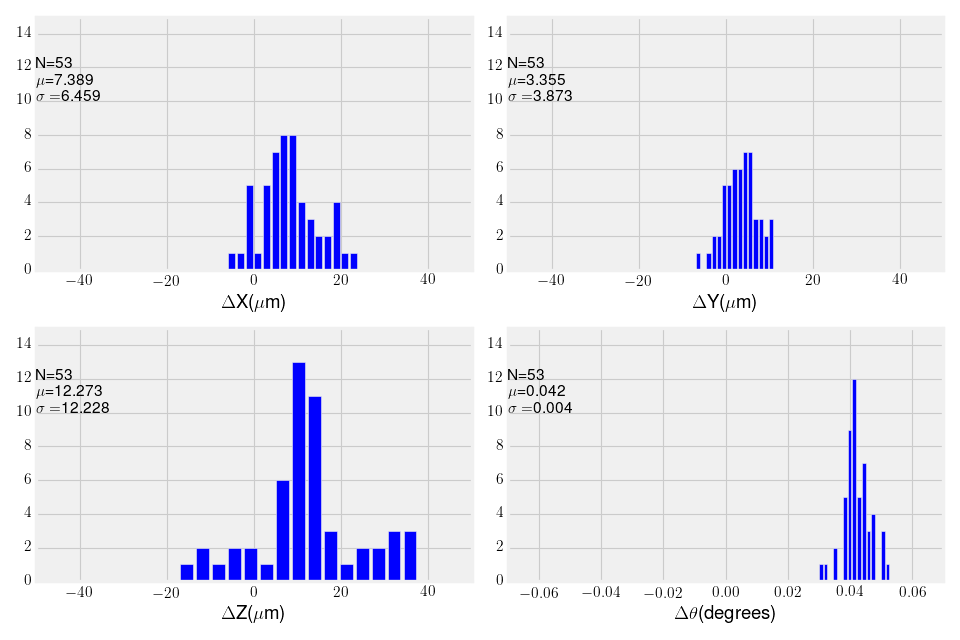

<IPython.core.display.Javascript object>


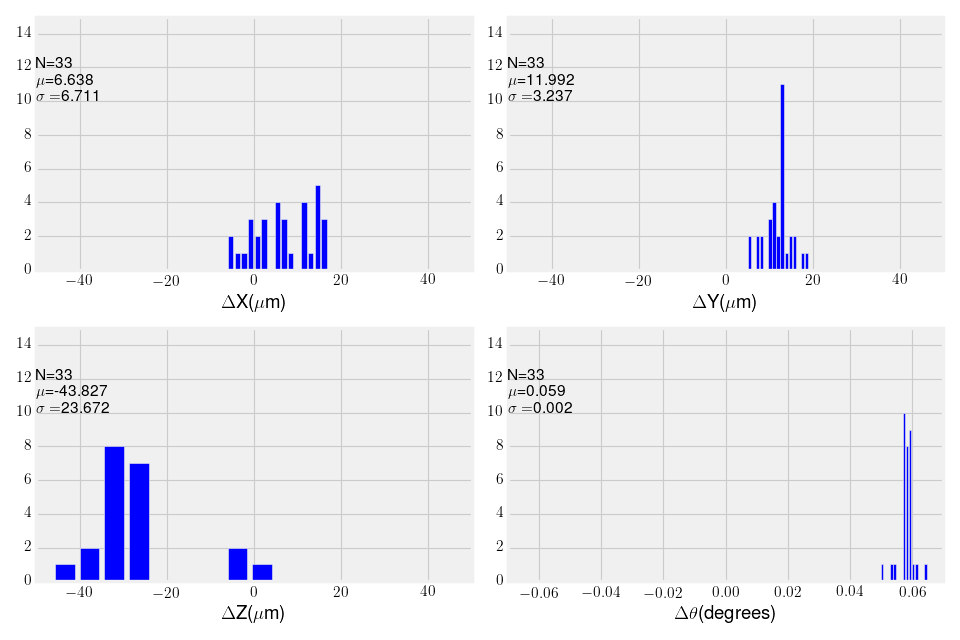

In [4]:
def delta_summary(data):
    fig, axs = plt.subplots(nrows=2, ncols=2)

    def histo(data, ax, xlabel, xlim=None, ymax=None):

        hist, bins = np.histogram(data, bins=15)
        width = 0.8 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        ax.bar(center, hist, align='center', width=width)
        ax.set_xlabel(xlabel)
        if xlim is None:
            xlim = (bins[0], bins[-1])
        ax.set_xlim(xlim)
        if ymax is not None:
            ax.set_ylim((0,ymax))

        fmt = "N={}\n$\mu$={:.3f}\n$\sigma=${:.3f}"
        label = fmt.format(len(data), np.mean(data), np.std(data))
        ax.text(xlim[0], 10, label)

    xs, ys, zs, ts = zip(*[(ob.x-target.x, 
                            ob.y-target.y,
                            ob.z-target.z,
                            ob.t-target.t) for ob in data])
    histo(xs, axs[0][0], r'$\Delta$X($\mu$m)', (-50,50), 15)
    histo(ys, axs[0][1], r'$\Delta$Y($\mu$m)', (-50,50), 15)
    histo(zs, axs[1][0], r'$\Delta$Z($\mu$m)', (-50,50), 15)
    histo(ts, axs[1][1], r'$\Delta\theta$(degrees)', (-.07, .07), 15)
    plt.tight_layout()
delta_summary(obs[50.1])
delta_summary(obs[50])
delta_summary(obs[49.8])


<IPython.core.display.Javascript object>


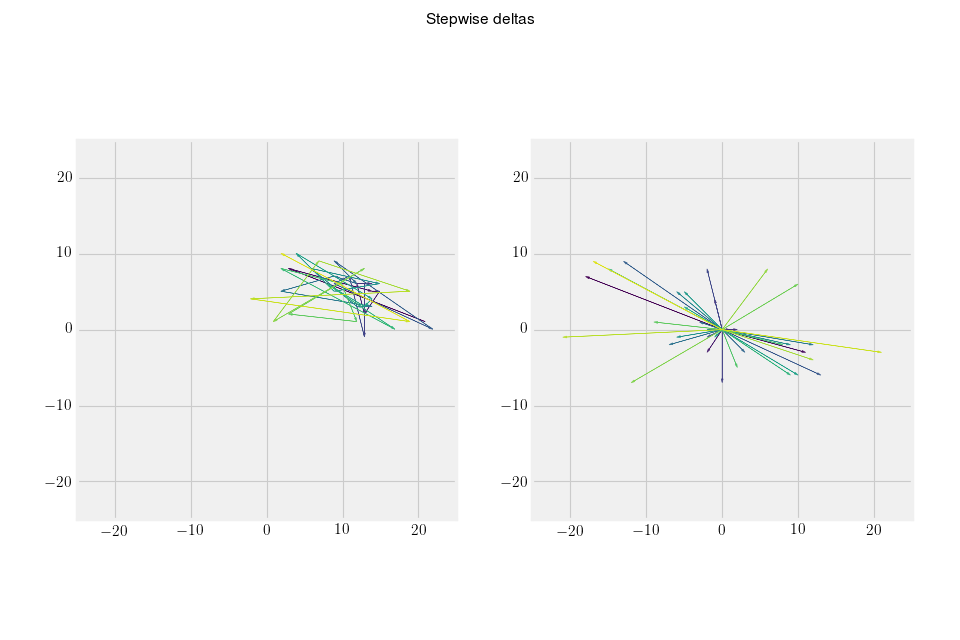

<IPython.core.display.Javascript object>


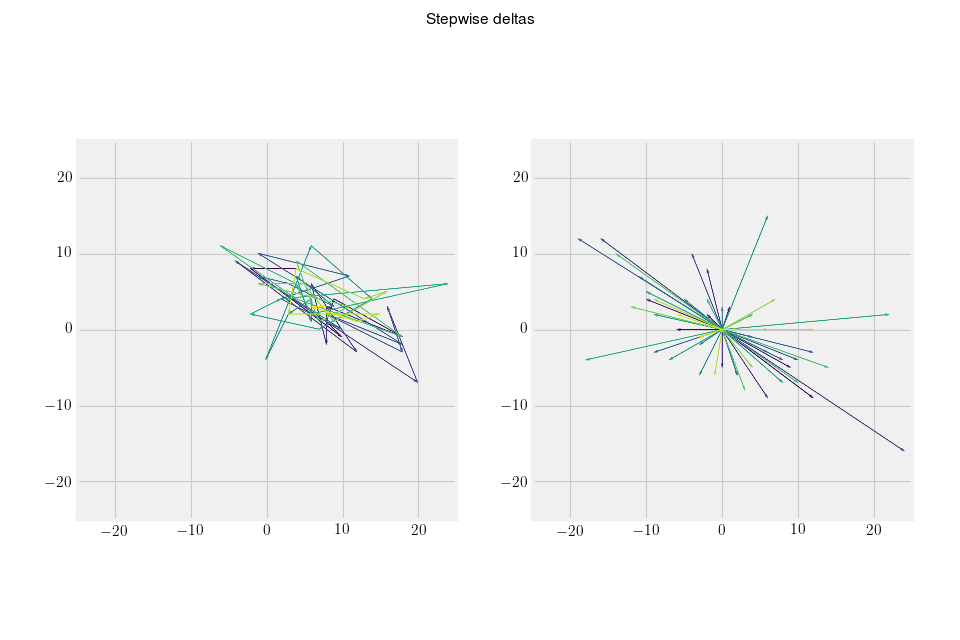

<IPython.core.display.Javascript object>


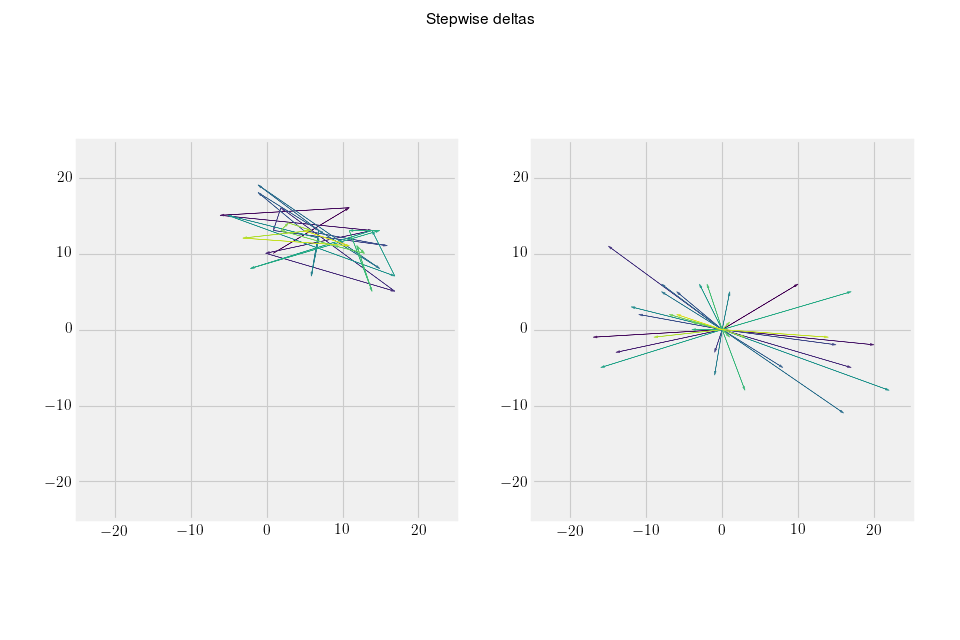

In [5]:
def stepwise_summary(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.set_aspect(1)
    ax2.set_aspect(1)
    cmap = cm.get_cmap('viridis')

    for ob1, ob2 in zip(data[:-1],data[1:]):
        color = cmap(ob1.i/len(data))
        ax1.arrow(ob1.x-target.x, ob1.y-target.y,
                  ob2.x-ob1.x, ob2.y-ob1.y,
                  head_width=0.25, head_length=.5, fc=color, ec=color,
                  length_includes_head=True)
        ax2.arrow(0, 0,
                  ob2.x-ob1.x, ob2.y-ob1.y,
                  head_width=0.25, head_length=.5, fc=color, ec=color,
                  length_includes_head=True)

    ax1.autoscale()
    ax2.autoscale()
    ax1.set_xlim((-25, 25))
    ax1.set_ylim((-25, 25))
    ax2.set_xlim((-25, 25))
    ax2.set_ylim((-25, 25))
    fig.suptitle("Stepwise deltas")
stepwise_summary(obs[50.1])
stepwise_summary(obs[50])
stepwise_summary(obs[49.8])

<IPython.core.display.Javascript object>


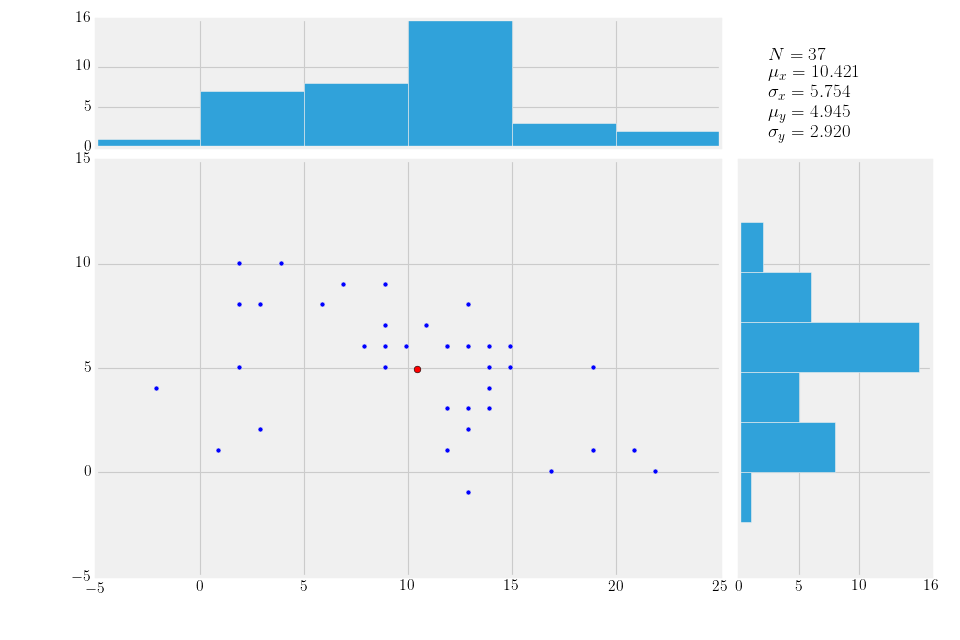

<IPython.core.display.Javascript object>


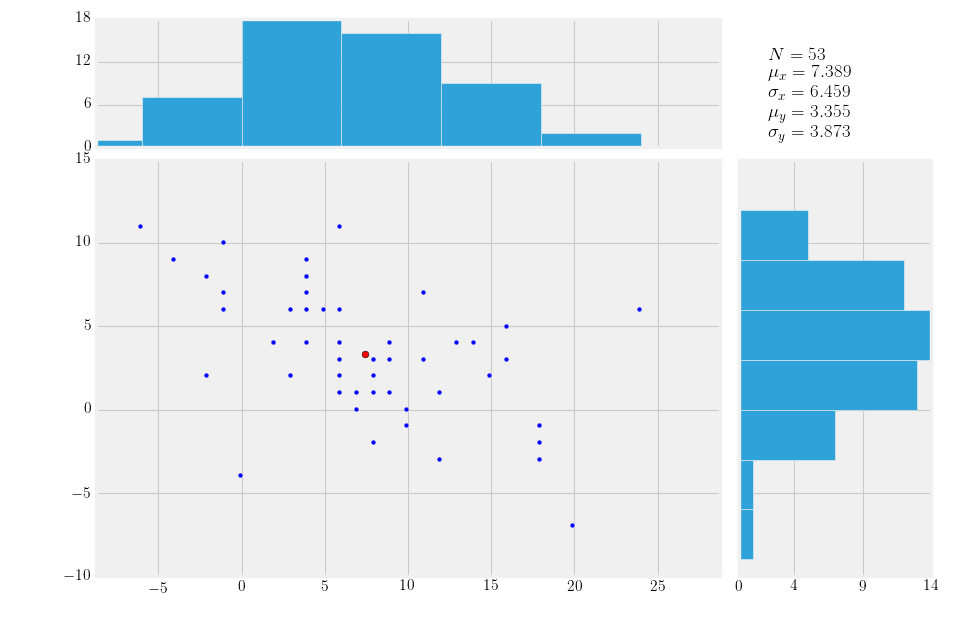

<IPython.core.display.Javascript object>


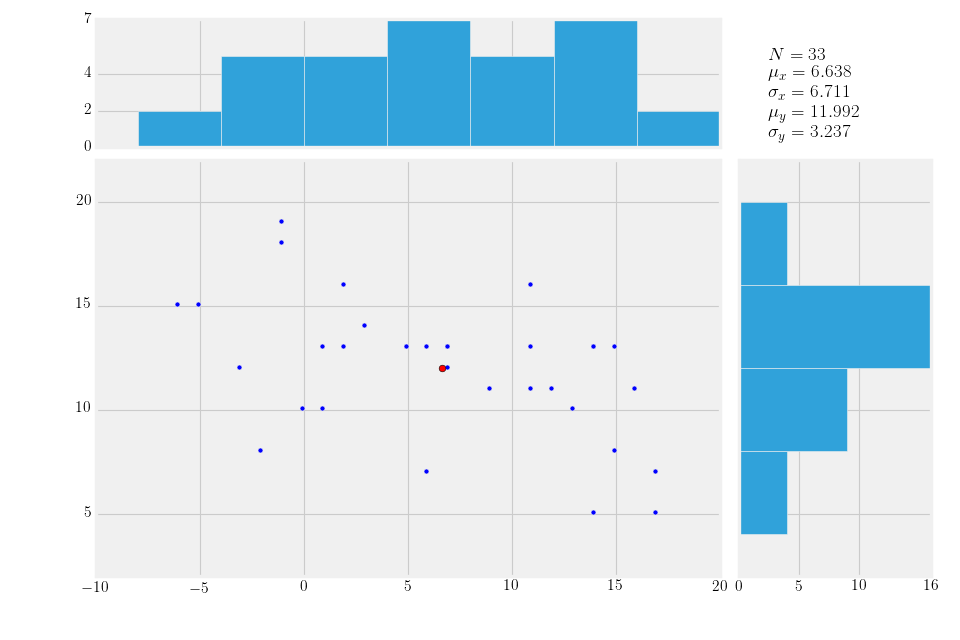

In [6]:
from scatter_hist import scatter_hist
def delta_summary(data):
    fig = plt.figure()

    xs, ys, zs, ts = zip(*[(ob.x-target.x, 
                            ob.y-target.y,
                            ob.z-target.z,
                            ob.t-target.t) for ob in data])
    scatter_hist(xs,ys, fig, plot_mean=True)
delta_summary(obs[50.1])
delta_summary(obs[50])
delta_summary(obs[49.8])

<IPython.core.display.Javascript object>


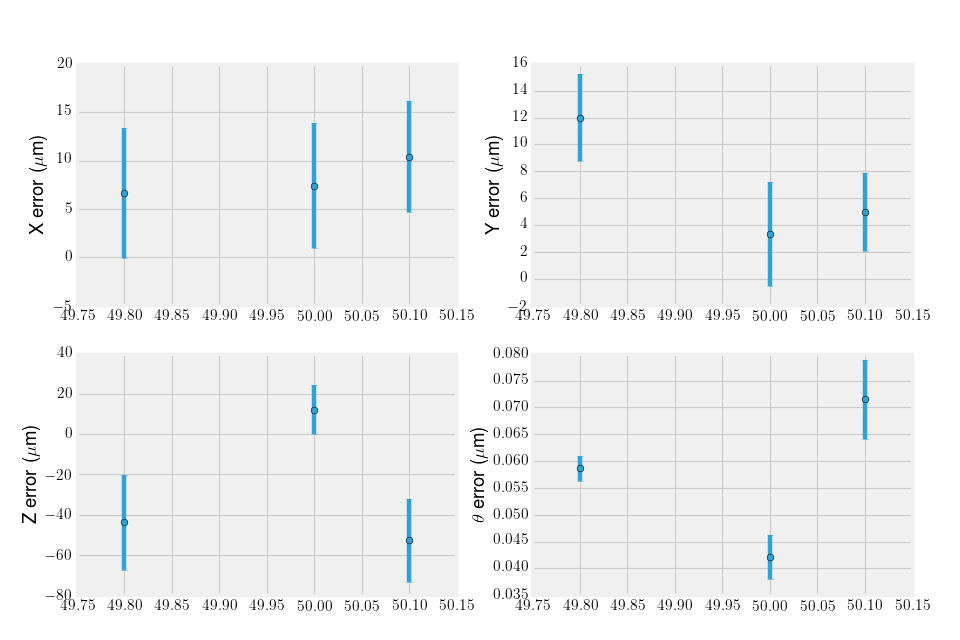

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2)

def proc_data(data):
    f = lambda xs: (np.mean(xs), np.std(xs))
    return map(f,zip(*[(ob.x-target.x, ob.y-target.y, ob.z-target.z, ob.t-target.t) for ob in data]))
xdat, ydat, zdat, tdat = zip(*map(proc_data, [obs[50.1], obs[50], obs[49.8]]))

pts, err = zip(*xdat)
axs[0,0].errorbar([50.1, 50, 49.8], pts, yerr=err, fmt='o')
axs[0,0].set_xlim(49.75,50.15)
axs[0,0].set_ylabel("X error ($\\mu$m)")

pts, err = zip(*ydat)
axs[0,1].errorbar([50.1, 50, 49.8], pts, yerr=err, fmt='o')
axs[0,1].set_xlim(49.75,50.15)
axs[0,1].set_ylabel("Y error ($\\mu$m)")

pts, err = zip(*zdat)
axs[1,0].errorbar([50.1, 50, 49.8], pts, yerr=err, fmt='o')
axs[1,0].set_xlim(49.75,50.15)
axs[1,0].set_ylabel("Z error ($\\mu$m)")

pts, err = zip(*tdat)
axs[1,1].errorbar([50.1, 50, 49.8], pts, yerr=err, fmt='o')
axs[1,1].set_xlim(49.75,50.15)
axs[1,1].set_ylabel("$\\theta$ error ($\\mu$m)")